# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [5]:
%%capture --no-stderr
%pip install --quiet -U langchain_groq langchain_core langgraph langgraph-prebuilt

In [6]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [15]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

In [8]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model="openai/gpt-oss-120b",
                 api_key = os.environ.get("OPENAI_API_KEY"),
)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [9]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

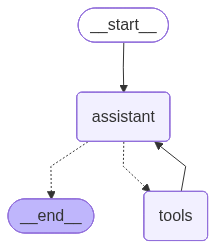

In [10]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (fc_fdb1929d-4880-4382-b63a-2fe7cce81f32)
 Call ID: fc_fdb1929d-4880-4382-b63a-2fe7cce81f32
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_15b8cca7-ac53-435a-826d-5832ad30702a)
 Call ID: fc_15b8cca7-ac53-435a-826d-5832ad30702a
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (fc_845f4ef1-68b4-4ecb-9c56-94871b39694d)
 Call ID: fc_845f4ef1-68b4-4ecb-9c56-94871b39694d
  Args:
    a: 14
    b: 5
==

## LangSmith

We can look at traces in LangSmith.

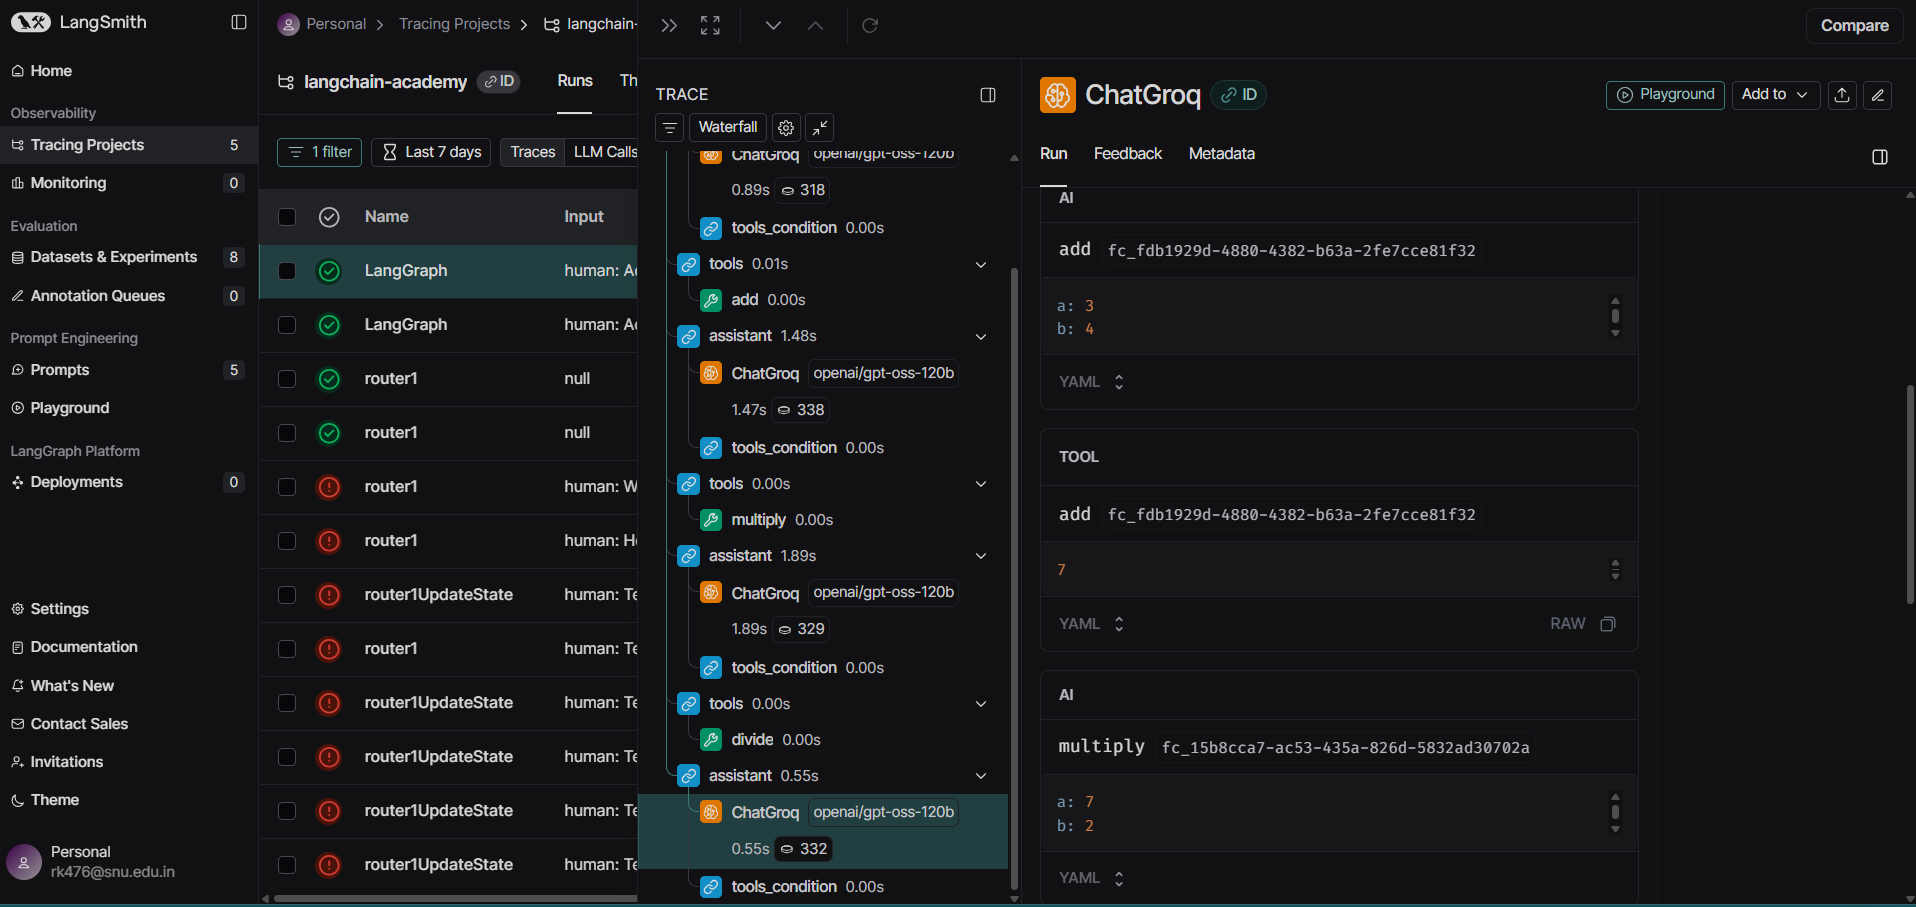

# MY EXAMPLES:

Create Python functions for different tasks.


In [16]:
def capitalize_string(input_string: str) -> str:
    """Capitalizes the input string.

    Args:
        input_string: The string to capitalize.

    Returns:
        The capitalized string.
    """
    return input_string.capitalize()

def reverse_string(input_string: str) -> str:
    """Reverses the input string.

    Args:
        input_string: The string to reverse.

    Returns:
        The reversed string.
    """
    return input_string[::-1]

def string_length(input_string: str) -> int:
    """Calculates the length of the input string.

    Args:
        input_string: The string to measure.

    Returns:
        The length of the string.
    """
    return len(input_string)

Bind the newly defined tools to the LLM.


In [17]:
string_tools = [capitalize_string, reverse_string, string_length]

llm_with_string_tools = llm.bind_tools(string_tools, parallel_tool_calls=False)

Create a new LangGraph StateGraph with nodes for the assistant and tools.


In [23]:
from langgraph.graph import StateGraph, MessagesState

string_sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing string manipulation on a set of inputs.")

def string_assistant(state: MessagesState):
    return {"messages": [llm_with_string_tools.invoke([string_sys_msg] + state["messages"])]}

string_graph_builder = StateGraph(MessagesState)

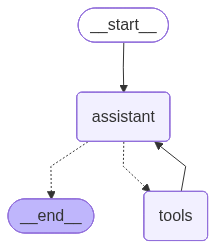

In [24]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import START
from langgraph.prebuilt import tools_condition

string_graph_builder.add_node("assistant", string_assistant)
string_graph_builder.add_node("tools", ToolNode(string_tools))
string_graph_builder.add_edge(START, "assistant")
string_graph_builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
string_graph_builder.add_edge("tools", "assistant")

string_react_graph = string_graph_builder.compile()

display(Image(string_react_graph.get_graph(xray=True).draw_mermaid_png()))

Invoke the new graph with a user message to demonstrate its functionality.


In [25]:
from langchain_core.messages import HumanMessage

string_messages = [HumanMessage(content="Capitalize the string 'hello world' and then find its length")]
string_messages = string_react_graph.invoke({"messages": string_messages})

In [26]:
for m in string_messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Capitalize the string 'hello world' and then find its length
================================== Ai Message ==================================
Tool Calls:
  capitalize_string (fc_c0a60ed7-202d-4ecc-b64c-9d514306c50e)
 Call ID: fc_c0a60ed7-202d-4ecc-b64c-9d514306c50e
  Args:
    input_string: hello world
================================= Tool Message =================================
Name: capitalize_string

Hello world
================================== Ai Message ==================================
Tool Calls:
  string_length (fc_eca9324d-b717-4fb0-ba44-8f7bb0b3333c)
 Call ID: fc_eca9324d-b717-4fb0-ba44-8f7bb0b3333c
  Args:
    input_string: Hello world
================================= Tool Message =================================
Name: string_length

11
================================== Ai Message ==================================

The capitalized string is **“Hello world”**, and its length is **11** 

*In Langsmith:*

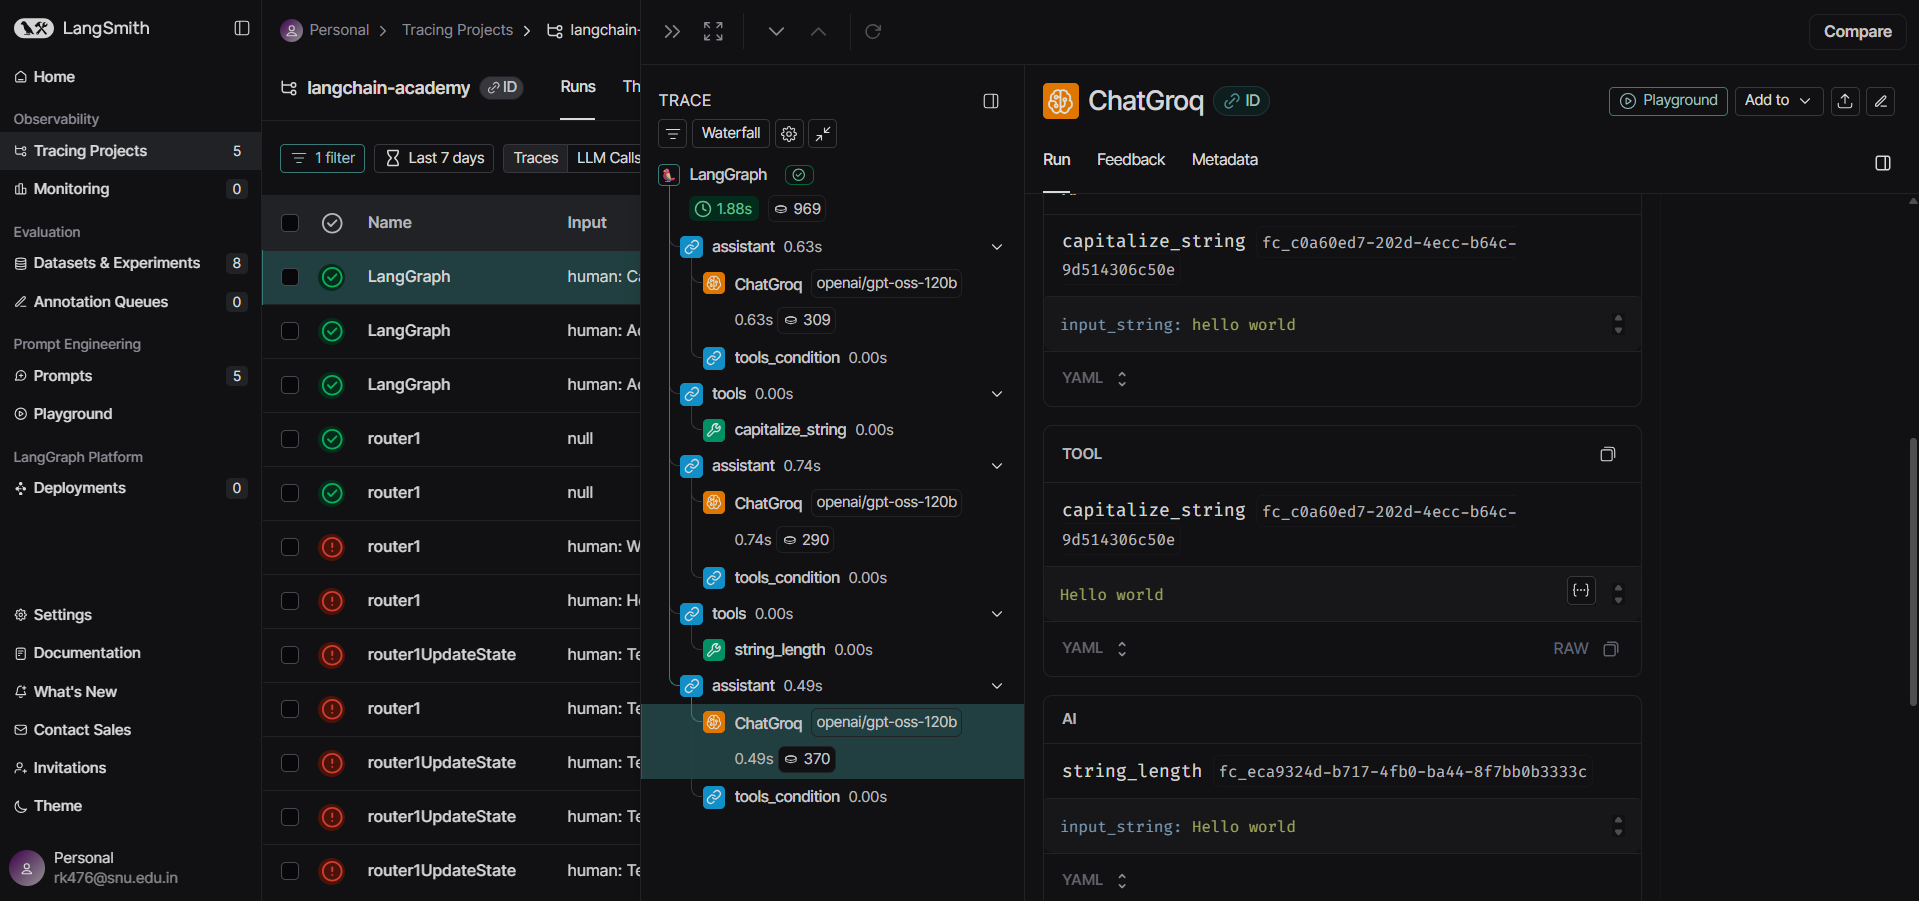